# Stock Market Prices Analysis and Prediction
### MLOps Zoomcamp Final Project

#### Import Dependencies
Let's import some libraries/modules that are commonly used in data analysis, financial analysis, and plotting.

<li>The <b>pandas_datareader</b> library provides a convenient interface for accessing various financial data sources</li>
<li> <b>yfinance</b> is a library that provides an interface to Yahoo Finance, allowing users to fetch financial data for analysis.</li>
<li><b>NumPy</b> is a fundamental package for scientific computing, providing support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.</li>
<li> <b>datetime module</b>, provides classes for manipulating dates and times</li>
<li><b>pandas_ta</b> is an extension library for Pandas that adds various technical analysis indicators and overlays.</li>
<li><b>talib</b> is a popular technical analysis library that provides functions for calculating various technical indicators.</li>
<li><b>mplfinance</b> is a library that provides a high-level interface for creating financial market visualizations using matplotlib.</li>
<li> <b>seaborn</b> is a data visualization library built on top of matplotlib, providing a high-level interface for creating attractive and informative statistical graphics.</li>



In [1]:
#Import libraries
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import datetime
import pandas_ta as ta
import talib as tb
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import tensorflow as tf
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import plot_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

yf.pdr_override()
%matplotlib inline


##### Getting Stock Data
We need to fetch the daily stock prices for a given stock symbol. To do so, we're going to use Yahoo Finance up to a specified end date. obtained data must be printed as preview and exported to a CSV file with a filename based on the stock symbol and end date. 

In [2]:
# Daily stock prices from Yahoo Finance
def get_stock_prices(symbol: str, end : str):
    '''Fetches daily stock prices from Yahoo Finance for a specified stock symbol up to a given end date. 
    It then adds the stock symbol to the data, resets the index, prints a preview of the data, 
    and exports it to a CSV file. 
    The CSV file is saved with a filename based on the stock symbol and end date.
    
    Parameters:
    ------------  
    symbol (String): A string representing the stock symbol for which to fetch the prices.
    end (String): A string representing the end date until which to fetch the prices in the format 'YYYY-MM-DD'.

    Returns:
    --------.
    df.to_csv (dataframe): dataframe is saved as csv using comma as separator and index false
    
    '''
    end_date = datetime.datetime.strptime(end, '%Y-%m-%d')
    df = pdr.get_data_yahoo(symbol, end=end_date)
    df['Symbol'] = symbol
    df.reset_index(inplace=True)
    end = end.replace('-', '')
    print(df.tail())
    return df.to_csv(f'../data/{symbol}_{end}.csv', sep=',', index=False)

We are going to analyse Google stock prices up to May-31 of 2023. 

In [3]:
#Google stock daily prices
get_stock_prices('AAPL', '2023-06-01')

[*********************100%***********************]  1 of 1 completed
            Date        Open        High         Low       Close   Adj Close  \
10701 2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
10702 2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
10703 2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
10704 2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   
10705 2023-05-31  177.330002  179.350006  176.759995  177.250000  177.250000   

         Volume Symbol  
10701  45143500   AAPL  
10702  56058300   AAPL  
10703  54835000   AAPL  
10704  55964400   AAPL  
10705  99625300   AAPL  


#### Technical Indicators
Next, we list some technical indicators which are useful in trading strategies such as: 
<li>% Return</li>
<li>Log Return</li>
<li>SMA_50</li>
<li>SMA_200</li>
<li>EMA_50</li>
<li>EMA_200</li>
<li>MACD</li>
<li>RSI</li>

In [4]:
def technical_indicators(df_path: str):
    '''The function performs various technical indicator 
    calculations on the stock data read from the CSV file.
    Parameters:
    ------------
    df_path (String): A string representing the file path of the CSV file containing the stock data.

    Returns:
    --------
    df (dataframe): Updated DataFrame with technical indicators.
    '''    
    df = pd.read_csv(df_path, sep=',', index_col='Date')
    df.ta.log_return(cumulative=True, append=True)
    df.ta.percent_return(cumulative=True, append=True)
    df['EMA_50'] = df.ta.ema(length=50, append=True)
    df['EMA_100'] = df.ta.ema(length=100, append=True)
    df['SMA_50'] = df.ta.sma(length=50, append=True)
    df['SMA_100'] = df.ta.sma(length=100, append=True)
    df['MACD'] = tb.MACD(df['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)[0]
    df['RSI'] = tb.RSI(df['Close'].values, timeperiod=14)
    df.rename(columns = {'CUMLOGRET_1':'Log Return', 'CUMPCTRET_1':'% Return'}, inplace = True)
    print(df.tail())
    return df


In [5]:
data = technical_indicators(df_path='../data/AAPL_20230601.csv')

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   
2023-05-31  177.330002  179.350006  176.759995  177.250000  177.250000   

              Volume Symbol  Log Return     % Return      EMA_50     EMA_100  \
Date                                                                           
2023-05-24  45143500   AAPL    7.199574  1337.860020  165.780255  159.559119   
2023-05-25  56058300   AAPL    7.206244  1346.820107  166.062990  159.825078   
2023-05-26  54835000   AAPL    7.220250  1365.830822  166.430324  160.134086   
2023-05-30  55964400   AAPL    7.230853  1380.400667  166.856586  160.474005   
2

In [6]:
def plot_split_data(df, n:int):
    '''The function generates and displays plots 
    related to Moving Average Convergence Divergence (MACD) and 
    Relative Strength Index (RSI) indicators. 
    It then returns a candlestick chart plot 
    with the specified customizations.
    
    Parameters:
    ------------
    df (DataFrame): A pandas DataFrame containing stock data.
    n (int): An integer representing the number of periods of data to consider.


    '''
    dir = "./img/"
    company = df['Symbol'][0]
    df = df.tail(n)
    df.index = pd.to_datetime(df.index)  # Convert index to DatetimeIndex
    dates = df.index.strftime('%B, %Y')  # Format dates
    date_1 = dates[0]
    date_2 = dates[n-2]
    
    macd_plot = mpf.make_addplot(df["MACD"], panel=3, color='fuchsia', title="MACD")
    macd_hist_plot = mpf.make_addplot(df["MACD"], type='bar', panel=3) 
    df['signal'] = df["MACD"].ewm(span=9).mean()
    macd_signal_plot = mpf.make_addplot(df["signal"], panel=3, color='b')
    rsi_plot = mpf.make_addplot(df['RSI'], panel=2, color='red', title='RSI')
    plots = [macd_plot, macd_signal_plot, macd_hist_plot, rsi_plot]

    plt.show()

    return mpf.plot(df, type='candle', style='yahoo', volume=True, mav=(50, 25),
                    tight_layout=True, figratio=(10, 5), addplot=plots,
                    title=f"{company} {date_1} - {date_2}",
                    panel_ratios=(.35, .1, .15, .15),
                    datetime_format='%b %d',
                    xrotation=0,
                    returnfig=True)


C:\Users\javie\AppData\Local\Temp\ipykernel_15404\3293302996.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df["MACD"].ewm(span=9).mean()


(<Figure size 1150x575 with 8 Axes>,
 [<Axes: ylabel='Price'>,
  <Axes: >,
  <Axes: ylabel='Volume  $10^{6}$'>,
  <Axes: >,
  <Axes: title={'center': 'RSI'}>,
  <Axes: >,
  <Axes: title={'center': 'MACD'}>,
  <Axes: >])

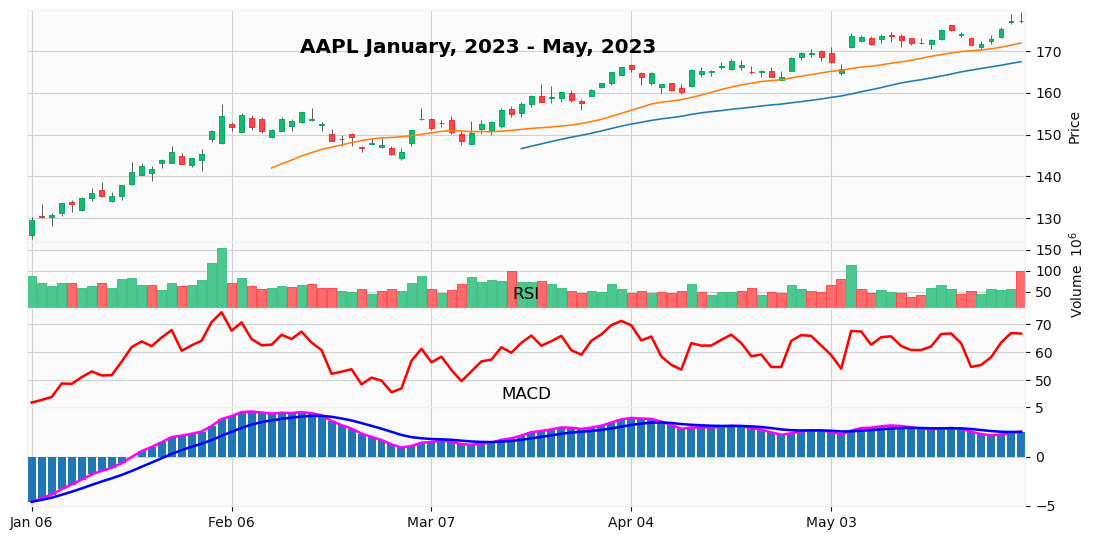

In [7]:
#we plot the Open-High-Low-Close of Google Stock prices in the last 100 periods
# Macd, RSI, Volume and 50 and 25 SMA are included
plot_split_data(df=data, n=100)

### Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an essential step in this project since it provides a better understanding of the underlying patterns and relationships in the data. We're going to start by exploring data to understand its structure and contents. We also performed data cleaning to ensure that the data was in the correct format and removed outliers.
Also, we are going to visualize the data using various charts, such as heat maps, boxplots and histograms. We are going to visualize the stock prices, returns and some technical indicators as well.
<li>Outliers</li>


In [8]:
#Detect Outliers
def detect_outliers(df, column: str, min_quantile: float, max_quantile: float):
    '''
    The function detects outliers in the specified column of the input DataFrame 
    based on the given quantiles and returns a DataFrame containing those outliers.
    
    Parameters:
    ------------
    df (DataFrame): A pandas DataFrame containing the data.
    column (string): A string representing the column name in the DataFrame where outliers will be detected.
    min_quantile (float): Represents the lower quantile value used to calculate the lower bound for outlier detection. 
                            It determines the threshold below which data points are considered outliers.
    max_quantile (float): Represents the upper quantile value used to calculate the upper bound for outlier detection. 
                        It determines the threshold above which data points are considered outliers.

    Returns:
    ---------
    outliers (DataFrame): A new DataFrame containing the outliers.
    '''
    q1 = df[column].quantile(min_quantile)
    q3 = df[column].quantile(max_quantile)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [9]:
#We show numbers of outliers, max and min outlier value and the last 10 outliers detected
outliers = detect_outliers(df=data, 
                        column='Close',
                        min_quantile=0.25, 
                        max_quantile=0.75)
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers['Close'].max()))
print("min outlier value: "+ str(outliers['Close'].min()))
print("Some Outliers: ", outliers['Close'].tail(10))

number of outliers: 1271
max outlier value: 182.00999450683597
min outlier value: 43.54499816894531
Some Outliers:  Date
2023-05-17    172.690002
2023-05-18    175.050003
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
Name: Close, dtype: float64


We need to clean our data by getting rid outliers of it. Let's handle with them

In [10]:
# Handle outliers
def handle_outliers(df, column):
    '''
    The function returns the filtered DataFrame.
    
    Parameters:
    -----------
    df (DataFrame): The input DataFrame containing the data.
    column (str): The column name in the DataFrame for which outliers will be handled.

    Returns:
    ---------
    df(DataFrame): The filtered DataFrame with the rows containing outliers removed.

    '''
    outliers = detect_outliers(df=data, 
                            column='Close',
                            min_quantile=0.25, 
                            max_quantile=0.75)
    return df[df[column] <= outliers[column].min()]

In [11]:
data_cleaned = handle_outliers(df=data, column='Close')
data_cleaned.tail()

,Open,High,Low,Close,Adj Close,Volume,Symbol,Log Return,% Return,EMA_50,EMA_100,SMA_50,SMA_100,MACD,RSI
Date,,,,,,,,,,,,,,,
2019-02-22,42.895000,43.250000,42.845001,43.242500,41.793896,75652800,AAPL,5.819834,335.916062,42.082695,44.070895,40.25240,45.614850,0.769640,62.289604
2019-02-28,43.580002,43.727501,43.230000,43.287498,41.837391,112861600,AAPL,5.820874,336.266657,42.297126,44.029657,40.36450,45.070425,0.777386,60.212238
2019-03-07,43.467499,43.610001,43.005001,43.125000,41.680336,99185600,AAPL,5.817113,335.000580,42.543425,43.994685,40.73905,44.455650,0.663489,54.810255
2019-03-08,42.580002,43.267502,42.375000,43.227501,41.779408,95997600,AAPL,5.819487,335.799197,42.570251,43.979493,40.86945,44.351800,0.603883,55.745682
2019-06-03,43.900002,44.480000,42.567501,43.325001,42.034893,161584400,AAPL,5.821740,336.558849,47.246915,46.836942,48.62940,45.486500,-1.543145,27.876406


<li>Boxplots</li>
We can create a box plot of the closing stock prices by Month (or other intervals) using the seaborn library.

In [12]:
def box_plot_by_period(df, column : str = 'Close', period : str  = 'Year'):
    ''' period can be Year or Month only '''
    if period == 'Month':
        df.loc[:, period] = pd.to_datetime(df.index).month
    else:
        df.loc[:, period] = pd.to_datetime(df.index).year
    plt.figure(figsize=(10,6))
    sns.boxplot(x=period, y=column, data=df, palette="Blues")
    plt.title(f'Close Stock Prices by {period}')
    plt.xlabel(period)
    plt.ylabel('Close Stock Price')
    locs, labels = plt.xticks()
    n = len(locs) // 5
    new_locs = locs[::n]
    new_labels = labels[::n]

    plt.xticks(new_locs, new_labels, rotation=45) 
    # plt.tight_layout()
    return plt.show()

C:\Users\javie\AppData\Local\Temp\ipykernel_15404\3513218446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, period] = pd.to_datetime(df.index).year


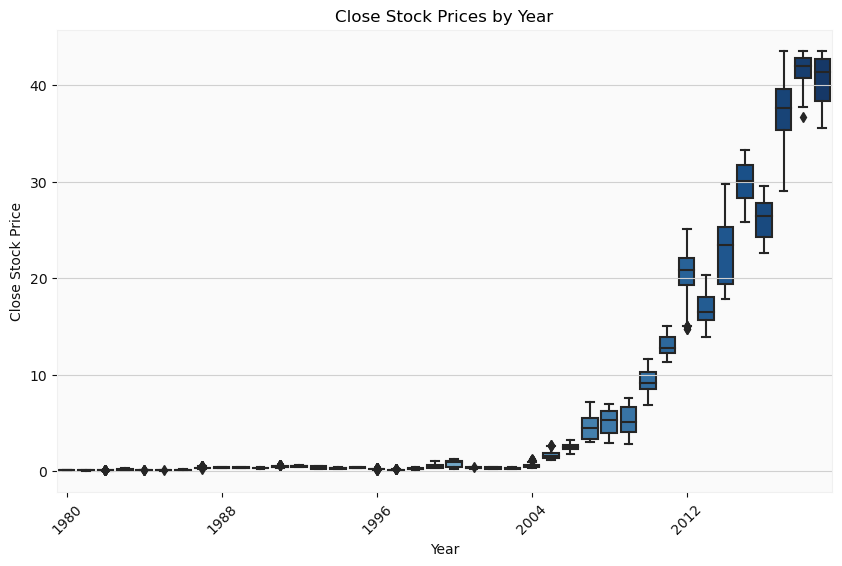

In [13]:
box_plot_by_period(df=data_cleaned, column='Close', period='Year')

From the plot, we can see that the closing stock prices have generally increased over the years, with some outliers on them. 

C:\Users\javie\AppData\Local\Temp\ipykernel_15404\3513218446.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, period] = pd.to_datetime(df.index).month


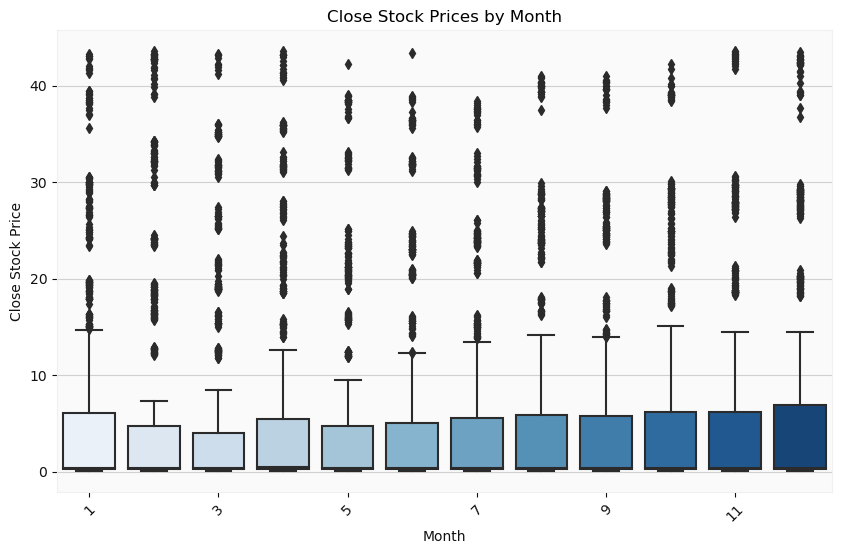

In [14]:
box_plot_by_period(df=data_cleaned, column='Close', period='Month')

we can see that the closing stock prices have generally kept stacionality over the months from 2004 to 2023.

<li>Cov Matrix</li>
<b>Heatmap</b> </br>
We can create a heatmap to visualize the correlation between the stock prices using the seaborn library.

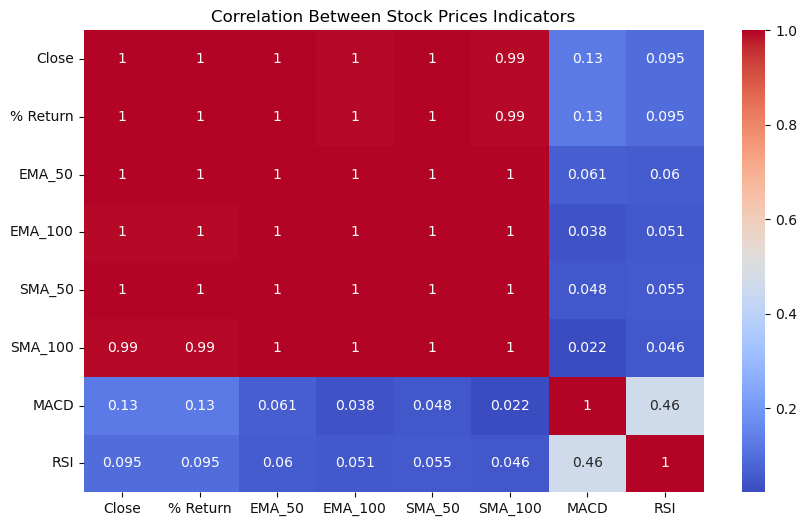

In [15]:
def check_covar(df):
    # Create a heatmap of the correlation between stock prices
    plt.rcParams["axes.grid"] = False
    data_corr = df[['Close', '% Return', 'EMA_50','EMA_100', 'SMA_50', 'SMA_100', 'MACD', 'RSI']]
    corr = data_corr.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True,cmap="coolwarm", linewidths=0.0, rasterized=True)
    plt.title('Correlation Between Stock Prices Indicators')
    return plt.show()
check_covar(df=data_cleaned)

We can start by visualizing the distribution of the target variable, which in this case is the closing stock price. We can use a histogram to visualize the distribution.

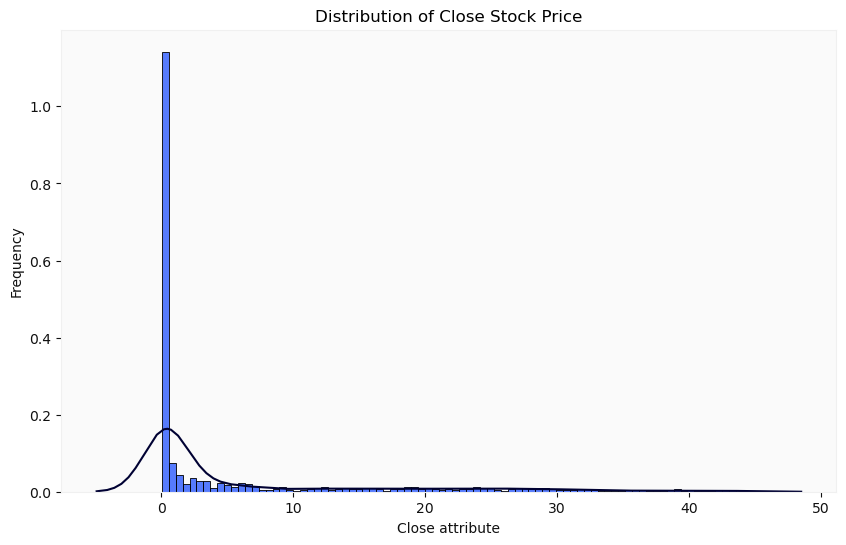

In [16]:
def price_dist(df, column):
    plt.figure(figsize=(10, 6))
    # plt.rcParams['axes.facecolor'] = 'darkgrey'
    h = sns.histplot(df[column], kde=False, color='#1F51FF', edgecolor='black', stat='density')
    sns.kdeplot(df[column], color='#000133', ax=h)
    plt.title(f'Distribution of {column} Stock Price')
    plt.xlabel(f'{column} attribute')
    plt.ylabel('Frequency')
    return plt.show()
price_dist(data_cleaned, column='Close')

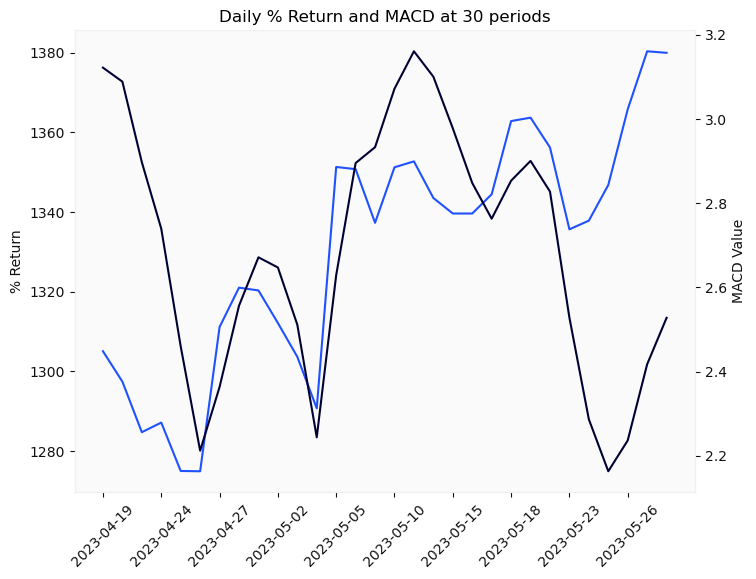

In [17]:
def attributes_behaviour(df, indicator_1, indicator_2, n):
    # Create a line chart of the daily returns
    n = n
    data_daily_return = df.tail(n)
    fig, ax = plt.subplots(figsize=(8,6))
    ax2 = ax.twinx()
    ax.plot(data_daily_return.index, data_daily_return[indicator_1], color='#1F51FF')
    ax2.plot(data_daily_return.index, data_daily_return[indicator_2], color='#000133')
    plt.title(f'Daily {indicator_1} and {indicator_2} at {n} periods')
    plt.xlabel('Date')
    ax.set_ylabel(f'{indicator_1}')
    ax2.set_ylabel(f'{indicator_2} Value')
    step_size = np.int8(n/10) or 5
    xticks = data_daily_return.index[::step_size]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=45)
    return plt.show()

attributes_behaviour(df=data, indicator_1='% Return', indicator_2='MACD', n=30)

In [18]:
def pairs_attributes_behaviour(df, attribute_pairs, n):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, )
    fig.tight_layout(pad=6.0)
    for i, (indicator_1, indicator_2) in enumerate(attribute_pairs):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        ax2 = ax.twinx()
        data_daily_return = df.tail(n)
        line1, = ax.plot(data_daily_return.index, 
                         data_daily_return[indicator_1], 
                         color='#1F51FF', 
                         label=indicator_1)
        line2, = ax2.plot(data_daily_return.index, 
                          data_daily_return[indicator_2], 
                          color='#000133', 
                          label=indicator_2)
        
        ax.set_title(f'Daily {indicator_1} and {indicator_2} at {n} periods')
        ax.set_xlabel('Date')
        ax2.set_ylabel(f'{indicator_2} Value')
        
        step_size = np.int8(n / 5) or 5
        xticks = data_daily_return.index[::step_size]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks, rotation=45)
        ax.legend(handles=[line1, line2], 
                  labels=[indicator_1, indicator_2], 
                  loc='upper left', 
                  bbox_to_anchor=(0.02, 0.98))
        
plt.show()


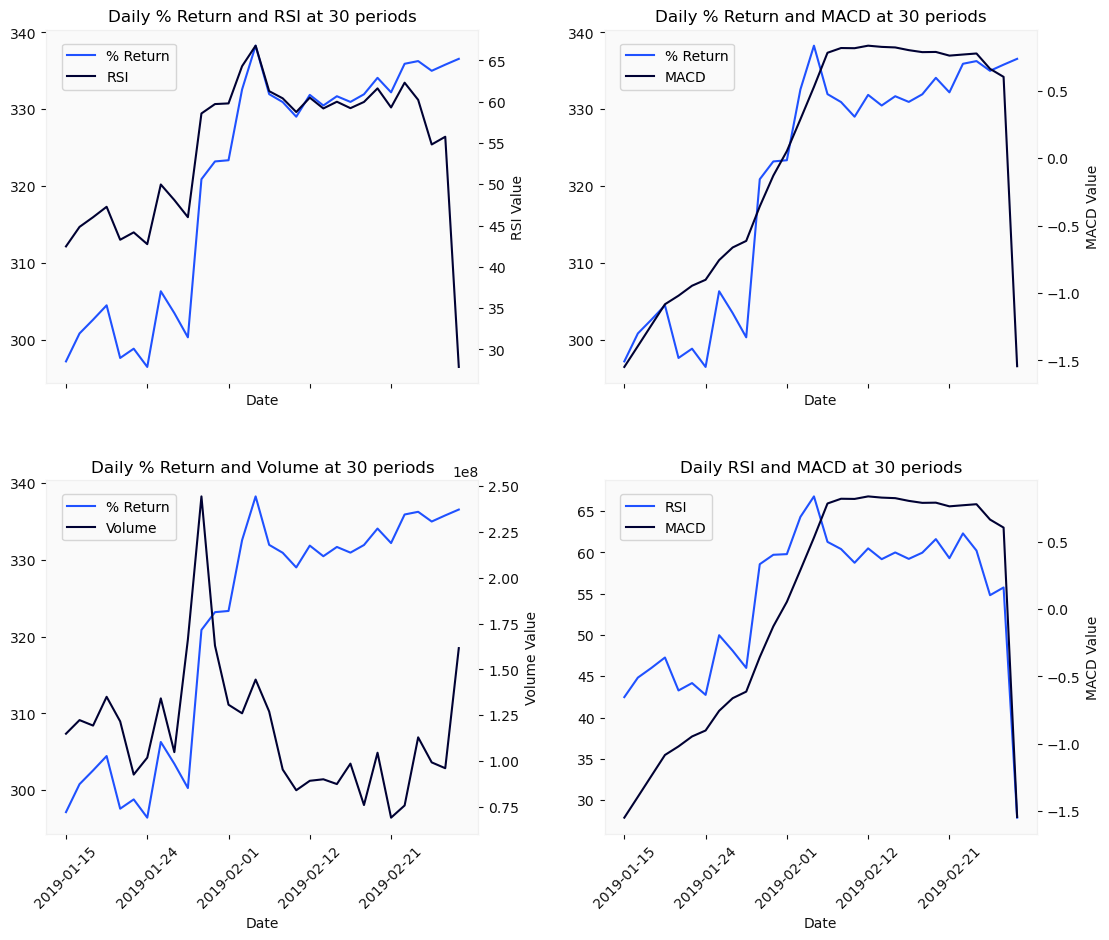

In [19]:
attribute_pairs = [('% Return', 'RSI'), ('% Return', 'MACD'), ('% Return', 'Volume'), ('RSI', 'MACD')]
pairs_attributes_behaviour(data_cleaned, attribute_pairs, 30)


### Pre-processing 

In [20]:
# data preprocessing
def data_preprocess(df):
    # features = ['Close', 'EMA_50', 'EMA_100', 'SMA_50', 'SMA_100', 'MACD', 'RSI']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data, columns=df.columns, index=df.index).dropna()
    return scaled_data


In [21]:
scaled_data = data_preprocess(data_cleaned.drop(columns=['Symbol', 'Year', 'Month', 'Volume', 'Open', 'High', 'Low'], axis=1))
scaled_data.tail(10)

,Close,Adj Close,Log Return,% Return,EMA_50,EMA_100,SMA_50,SMA_100,MACD,RSI
Date,,,,,,,,,,
2019-02-14,0.980573,0.981777,0.997113,0.980573,0.813701,0.860256,0.758122,0.882262,0.896481,0.586153
2019-02-15,0.978389,0.979590,0.996785,0.978389,0.814234,0.859642,0.756767,0.880005,0.891251,0.575927
2019-02-19,0.981320,0.982525,0.997225,0.981320,0.814843,0.859089,0.756225,0.877624,0.887420,0.585793
2019-02-20,0.987643,0.988854,0.998170,0.987643,0.815638,0.858653,0.755972,0.875228,0.887786,0.607365
2019-02-21,0.982067,0.983273,0.997337,0.982067,0.816218,0.858132,0.756214,0.872870,0.880714,0.577031
2019-02-22,0.993045,0.994262,0.998973,0.993045,0.817138,0.857806,0.756531,0.870387,0.882812,0.616409
2019-02-28,0.994080,0.995297,0.999126,0.994080,0.821308,0.857002,0.758641,0.859984,0.884823,0.589131
2019-03-07,0.990344,0.991558,0.998572,0.990344,0.826097,0.856320,0.765691,0.848237,0.855247,0.518198
2019-03-08,0.992701,0.993917,0.998922,0.992701,0.826619,0.856024,0.768145,0.846253,0.839769,0.530481


### Tunning Hyperparameters

### LSTM Model

In [22]:
def lstm_model_train(df: pd.DataFrame,
                  symbol: str = 'GOOG', 
                  selected_activation: str = 'relu', 
                  selected_learning_rate: float = 0.001, 
                  selected_epochs: int = 100, 
                  selected_batch_size: int = 30, 
                  selected_loss_function: str = 'mean_squared_error', 
                  plot_lstm_model: bool = False):
  ''' 
  Implements a Long Short-Term Memory (LSTM) model for stock price prediction based on given features. 
  The function takes in a pandas DataFrame containing historical stock prices and some technical indicators alongside 
  optional hyperparameters for the model by default, such as the selected optimizer, activation function, learning rate, 
  number of epochs, batch size, and loss function.
  The model is used to predict the test data with MSE and R^2 metrics computed. 
  The function returns a pandas DataFrame containing these metrics.
  If plot_lstm_model is set to True, the function also generates a visualization of 
  LSTM model and saves it to a png file.

  Parameters:
  ------------
  df (pd.DataFrame): A pandas dataframe containing the financial data to be used for analysis.
  features (list): List of features that is going to be considered in LSTM model.
  selected_optimizer (str, optional): Indicates the optimization algorithm to be used in training the LSTM model. Default is 'Adam'.
  selected_activation (str, optional): A string indicating the activation function to be used in the output layer of the LSTM model. Default is 'relu'.
  selected_learning_rate (float, optional): A float indicating the learning rate to be used in training the LSTM model. Default is 0.01.
  selected_epochs (int, optional): An integer indicating the number of epochs to be used in training the LSTM model. Default is 50.
  selected_batch_size (int, optional): An integer indicating the batch size to be used in training the LSTM model. Default is 32.
  selected_loss_function (str, optional): A string indicating the loss function to be used in training the LSTM model. Default is 'mean_squared_error'.
  plot_lstm_model (bool, optional): A boolean indicating whether or not to plot the LSTM model. Default is False

  
  Returns:
  ----------

  metrics_df (pd.DataFrame): A pandas dataframe containing the evaluation metrics of the LSTM model, 
  including MSE and R^2 metrics.

  '''

  stock_name = symbol
  X = np.array(df.drop('Close', axis=1))
  Y = np.array(df['Close'].values)

            
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

  timesteps = 10
  n_features = X.shape[1]
  
  X_train = np.array([X_train[i:i+timesteps] for i in range(len(X_train) - timesteps + 1)])
  X_test = np.array([X_test[i:i+timesteps] for i in range(len(X_test) - timesteps + 1)])

  Y_train = Y_train[timesteps - 1:]
  Y_test = Y_test[timesteps - 1:]

  
  X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
  X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

  selected_activation ='relu'
  selected_learning_rate = 0.01 
  selected_loss_function ='mse'
# Define the LSTM model
  model = Sequential()
  model.add(LSTM(units=200, 
                 return_sequences=True, 
                 input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(1, 
                  activation=selected_activation))

  optimizer = tf.keras.optimizers.Adam(learning_rate=selected_learning_rate)
  model.compile(
      loss=selected_loss_function, 
      optimizer=optimizer,
      metrics = ['mse', 'mae']
            )

  # Model training
  history = model.fit(X_train, 
                      Y_train, 
                      epochs=selected_epochs, 
                      batch_size=selected_batch_size, 
                      verbose=1)



  fig, ax = plt.subplots(figsize=(8,6)) 
  ax.plot(history.history['mse'], label='Training mse')
  ax2 = ax.twinx()
  ax2.plot(history.history['mae'], label='Training mae')
  plt.title(f'Training MSE and MAE of {stock_name} Stock')
  plt.xlabel('Epoch')
  ax.set_ylabel('MSE Value')
  ax2.set_ylabel('MAE Value')
  plt.legend()
  plt.show()                      

  if plot_lstm_model:
     plot_model(history.model, 
                to_file=f'../img/LSTM_Model.png', 
                show_shapes=True, 
                show_layer_activations=True,
                show_trainable=True)

  with open('../models/lstm_model.pkl', 'wb') as file:
      pickle.dump(history.model, file)              

  return history, X_test, Y_test

Epoch 1/80
133/133 [==============================] - 3s 7ms/step - loss: 0.0584 - mse: 0.0584 - mae: 0.1666
Epoch 2/80
133/133 [==============================] - 1s 6ms/step - loss: 0.0240 - mse: 0.0240 - mae: 0.1318
Epoch 3/80
133/133 [==============================] - 1s 6ms/step - loss: 0.0239 - mse: 0.0239 - mae: 0.1314
Epoch 4/80
133/133 [==============================] - 1s 7ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.1310
Epoch 5/80
133/133 [==============================] - 1s 6ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1298
Epoch 6/80
133/133 [==============================] - 1s 6ms/step - loss: 0.0233 - mse: 0.0233 - mae: 0.1300
Epoch 7/80
133/133 [==============================] - 1s 6ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1297
Epoch 8/80
133/133 [==============================] - 1s 7ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.1289
Epoch 9/80
133/133 [==============================] - 1s 6ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1293
Epoch 10/80
133/133

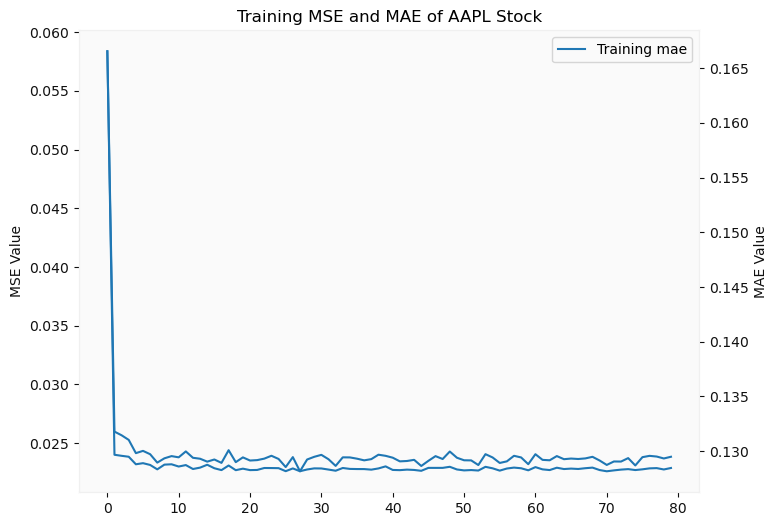

In [23]:
np.random.seed(44)
lstm, X_test_output, Y_test_output = lstm_model_train(scaled_data.tail(2000), 
                        'AAPL', 
                        plot_lstm_model=True, 
                        selected_epochs=80, 
                        selected_batch_size=12,
                        selected_learning_rate=0.001)
lstm

In [24]:
X_test_output.shape

(391, 10, 9)

In [25]:
# Model evaluation
min_value = np.min(data_cleaned['Close'])
max_value = np.max(data_cleaned['Close'])

Y_pred = lstm.model.predict(X_test_output)
Y_pred = Y_pred * (max_value - min_value) + min_value
reshaped_Y_pred = Y_pred.reshape((len(X_test_output), 10))
print(reshaped_Y_pred[0])

13/13 [==============================] - 0s 4ms/step
[20.877802 20.880064 20.881807 20.880796 20.88113  20.881752 20.884098
 20.885218 20.88893  20.886656]


In [26]:
first_column_y_pred = reshaped_Y_pred[:, 0]
first_column_y_pred

array([20.877802, 20.875986, 20.877142, 20.8761  , 20.876438, 20.877024,
       20.879221, 20.880198, 20.883657, 20.881424, 20.880331, 20.89499 ,
       20.90216 , 20.908194, 20.911724, 20.924006, 20.92687 , 20.938608,
       20.946878, 20.936129, 20.932547, 20.934036, 20.948904, 20.946096,
       20.95832 , 20.94973 , 20.932714, 20.931122, 20.929022, 20.919579,
       20.916994, 20.91777 , 20.913897, 20.913635, 20.913244, 20.917528,
       20.922792, 20.920624, 20.924969, 20.919619, 20.912958, 20.906757,
       20.898771, 20.900167, 20.893562, 20.891937, 20.88922 , 20.887789,
       20.885439, 20.883993, 20.883163, 20.887215, 20.88669 , 20.884722,
       20.887753, 20.888279, 20.894745, 20.894157, 20.895805, 20.893658,
       20.888937, 20.885616, 20.884874, 20.88301 , 20.886248, 20.887918,
       20.885235, 20.885338, 20.88721 , 20.88681 , 20.886875, 20.88834 ,
       20.882732, 20.882378, 20.88233 , 20.885487, 20.888624, 20.876997,
       20.876152, 20.874594, 20.873003, 20.871592, 

In [27]:
Y_test = Y_test_output * (max_value - min_value) + min_value
Y_test

array([29.41250038, 29.5625    , 28.89749908, 28.62000084, 28.43000031,
       28.38500023, 27.87249947, 27.89749908, 27.45750046, 27.20999908,
       27.60250092, 27.76499939, 27.71999931, 26.94750023, 27.10750008,
       26.42749977, 26.77750015, 27.49749947, 27.48749924, 27.51499939,
       27.93250084, 27.95000076, 27.80750084, 27.94750023, 27.89249992,
       27.86499977, 27.62999916, 27.37249947, 27.47500038, 27.27750015,
       27.48749924, 27.75749969, 28.03000069, 28.48749924, 28.32500076,
       28.79750061, 28.79750061, 28.95499992, 28.99250031, 29.15999985,
       29.23749924, 29.26499939, 29.07250023, 29.12999916, 29.31500053,
       29.19000053, 29.18250084, 28.95499992, 29.03750038, 29.00499916,
       29.15250015, 29.47750092, 29.74749947, 29.77750015, 29.9375    ,
       29.8125    , 29.76000023, 30.        , 29.99749947, 29.94499969,
       30.        , 30.02000046, 29.99250031, 30.46999931, 30.48500061,
       30.48749924, 30.40749931, 30.33749962, 32.1875    , 32.13

In [28]:
# Calculate evaluation metrics
mse = mean_squared_error(Y_test, first_column_y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, first_column_y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 287.5513184240985
Root Mean Squared Error (RMSE): 16.957338188055886
R-squared (R2) Score: -11.711012564518688


### MODEL REPRODUCIBILITY TESTING

In [29]:
# Loading the model
with open('../models/lstm_model.pkl', 'rb') as file:
    lstm_loaded_model = pickle.load(file)

In [30]:
#reshape X_testing data
def reshape_test_data(df: pd.DataFrame) -> np.ndarray:
  '''
    Reshapes the test data for LSTM model prediction.

    Parameters:
    -----------
    df (pd.DataFrame): A pandas DataFrame containing the test data.

    Returns:
    --------
    np.ndarray: The reshaped test data in the form of a 3D numpy array.

  '''
  X = np.array(df.drop('Close', axis=1))
  timesteps = 10
  n_features = X.shape[1]
  X_test = np.array([X[i:i+timesteps] for i in range(len(X) - timesteps + 1)])
  X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)
  return X_test

In [31]:
#testing pickle file
data_raw = technical_indicators(df_path='../data/TSLA_20230601.csv')
data_cleaned = handle_outliers(df=data_raw, column='Close')
data_preprocessed = data_preprocess(data_cleaned.drop(columns=['Symbol', 'Volume', 'Open', 'High', 'Low'], axis=1))
data_validation_reshaped = reshape_test_data(data_preprocessed)
data_validation_reshaped.shape

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-24  182.229996  184.220001  178.220001  182.899994  182.899994   
2023-05-25  186.539993  186.779999  180.580002  184.470001  184.470001   
2023-05-26  184.619995  198.600006  184.529999  193.169998  193.169998   
2023-05-30  200.100006  204.479996  197.529999  201.160004  201.160004   
2023-05-31  199.779999  203.949997  195.119995  203.929993  203.929993   

               Volume Symbol  Log Return    % Return      EMA_50     EMA_100  \
Date                                                                           
2023-05-24  137605100   TSLA    4.743530  113.838818  176.176448  180.937737   
2023-05-25   96870700   TSLA    4.752077  114.824591  176.501685  181.007683   
2023-05-26  162061500   TSLA    4.798161  120.287124  177.155344  181.248521   
2023-05-30  128818700   TSLA    4.838691  125.303870  178.096704  181.642807   
2

(2332, 10, 9)

In [32]:
def predictions_as_array(df: pd.DataFrame, X_array: np.ndarray, model) -> np.ndarray:
    '''
    Converts predictions to an array and applies inverse scaling.

    Parameters:
    -----------
    df (pd.DataFrame): A pandas DataFrame containing the original data for scaling.
    X_array (np.ndarray): A numpy array representing the input data for prediction.
    model: The trained LSTM model used for prediction.

    Returns:
    --------
    np.ndarray: The predictions as a 1D numpy array.
    
    '''
    min_value = np.min(df['Close'])
    max_value = np.max(df['Close'])

    Y_pred = model.predict(X_array)
    Y_pred = Y_pred * (max_value - min_value) + min_value
    reshaped_Y_pred = Y_pred.reshape((len(X_array), 10))
    return reshaped_Y_pred[0]

In [33]:
test_prediction = predictions_as_array(df=data_raw, 
                                        X_array=data_validation_reshaped, 
                                        model=lstm_loaded_model)
test_prediction

73/73 [==============================] - 1s 3ms/step


array([151.92955, 162.57564, 163.85959, 166.00717, 166.47821, 166.97186,
       166.59444, 164.68123, 166.1034 , 163.99057], dtype=float32)

In [34]:
def show_data_result(df: pd.DataFrame, y_predicted: np.ndarray, n: int, make_plot: bool = True) -> pd.DataFrame:
    ''' 
    Displays the data result with predicted values and optionally plots the data.

    Parameters:
    -----------
    df (pd.DataFrame): A pandas DataFrame containing the original data.
    y_predicted (np.ndarray): A numpy array representing the predicted values.
    n (int): The number of data points to display.
    make_plot (bool, optional): A boolean indicating whether to make a plot. Default is True.

    Returns:
    --------
    pd.DataFrame: A pandas DataFrame containing the data result.

    '''
    start_date = df.index[-1]
    dates = pd.date_range(start=pd.to_datetime(start_date) + pd.DateOffset(days=1), 
                            periods=len(y_predicted), 
                            freq='D')
    new_data = pd.DataFrame({'Close': y_predicted}, index=dates)
    data_result = pd.concat([data_raw, new_data])
    data_result.index = pd.to_datetime(data_result.index)
    data_result.index = data_result.index.tz_localize(None)
    data_result = data_result.tail(n)
    if make_plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(data_result.index, data_result['Close'], color='black', label='Real today')
        ax.plot(data_result.index[-10:], data_result['Close'][-10:], color='red', label='Next 10 days')
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price')
        ax.set_title('Close Prices')
        ax.legend()

        # Display the plot
        plt.show()
    return data_result[['Close']]


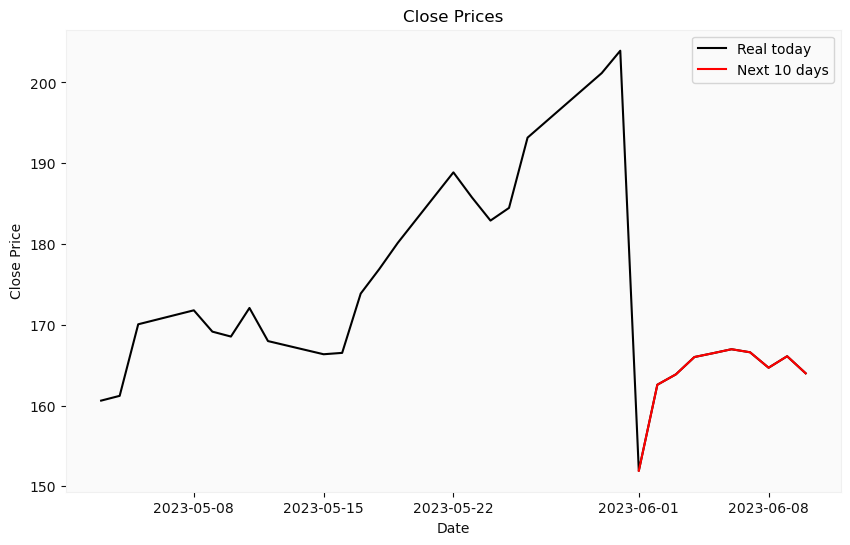

,Close
2023-05-03,160.610001
2023-05-04,161.199997
2023-05-05,170.059998
2023-05-08,171.789993
2023-05-09,169.149994
2023-05-10,168.539993
2023-05-11,172.080002
2023-05-12,167.979996
2023-05-15,166.350006
2023-05-16,166.520004


In [35]:
show_data_result(df=data_raw, y_predicted=test_prediction, n=30, make_plot=True)